# Evaluation

This notebook is meant to summarize the final results

In [1]:
import sys
import os
from pathlib import Path

# append path 
save_dir = Path().cwd() / "final_evaluation"
save_dir.mkdir(parents=True, exist_ok=True)
print(save_dir)

import torch
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score

import utils 
from gans.cgan import CGAN
from cic_ids_17_dataset import CIC17Dataset


sns.set_style("whitegrid")
sns.set_context("paper")
# sns.set_palette("Pastel1")
sns.set_palette("dark")
plt.rcParams['figure.figsize'] = (10, 6)

/Users/thomas/Google Drive/Colab Notebooks/TU/interdisciplinary_project/final_evaluation


In [2]:
# palettes= ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
# tips = sns.load_dataset("tips")

# for p in palettes:
#     print(p)
#     sns.set_palette(p)
#     sns.barplot(x="day", y="total_bill", data=tips)
#     plt.show()

## Validate classifier predictions (simple class condition)

Overall, we implemented 5 different model architectures:
- Conditional GAN (CGAN)
- Auxiliary Classifier GAN (ACGAN)
- Conditional Wasserstein GAN (WGAN)
- Conditional Wasserstein GAN with gradient penalty (WGAN-GP)
- Auxiliary Classifier Wasserstein GAN (ACWGAN)

For each model we evaluate 3 dimensions:
- external classifier predictions of generated flows (accuracy, weighted/macro f1-score/precision/recall)
- statistical significance tests
- euclidean distances

Additionally, we plot the confusion matric of the classifier and the distributions of (selected) generated features as compared with the actual distributions prevalent in the dataset. For each model we ran at least two random seeds. 

All of this is tracked in TensorBoard. We load the respective TensorBoard files, extrac the relevant metrics and average over the random seeds. 

### Load TensorBoard files

In [7]:
cgan_paths = ['./tensorboard/cgan/27-05-2021_15h06m/events.out.tfevents.1622127977.0628209fcda7',
              './tensorboard/cgan/20-05-2021_12h09m/events.out.tfevents.1621512544.85f4f2359f38']
wgan_paths = ["tensorboard/wgan/07-06-2021_11h37m/events.out.tfevents.1623065821.04dcd0ca8e7e", 
              "tensorboard/wgan/07-06-2021_14h07m/events.out.tfevents.1623074876.04dcd0ca8e7e"]
acwgan_paths = ["tensorboard/acwgan/09-06-2021_14h17m/events.out.tfevents.1623248244.b4684de013fe",
                "tensorboard/acwgan/09-06-2021_15h27m/events.out.tfevents.1623252448.b4684de013fe"]
acgan_paths = ["tensorboard/acgan/04-06-2021_11h38m/events.out.tfevents.1622806705.08cc070ead81",
               "tensorboard/acgan/04-06-2021_12h39m/events.out.tfevents.1622810344.08cc070ead81"]

all_paths = [*cgan_paths, *wgan_paths, *acwgan_paths, *acgan_paths]

architectures = np.repeat(["CGAN", "WGAN", "AC-WGAN", "AC-GAN"], 2)

df_tensorboard = utils.load_tf_event_files(all_paths, architectures=architectures)

100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


#### Classifier predictions

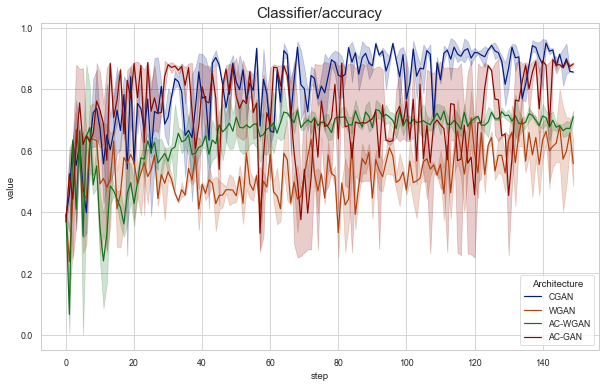

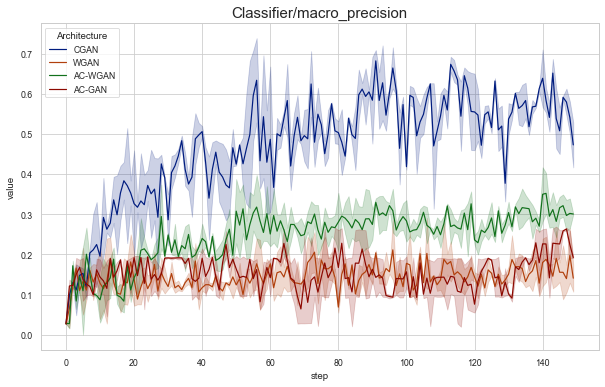

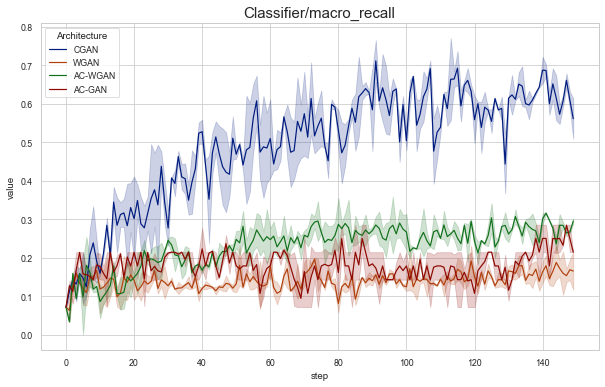

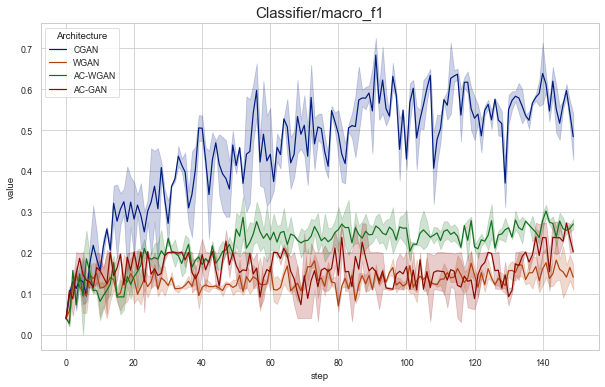

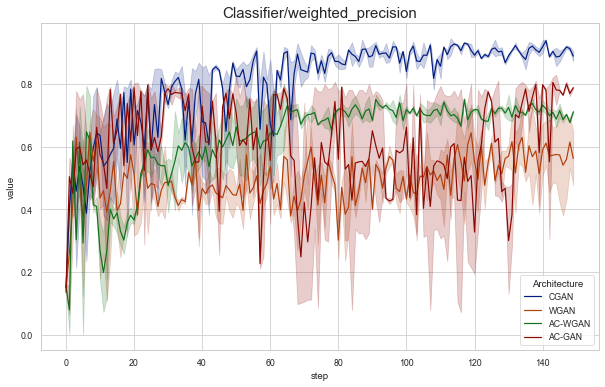

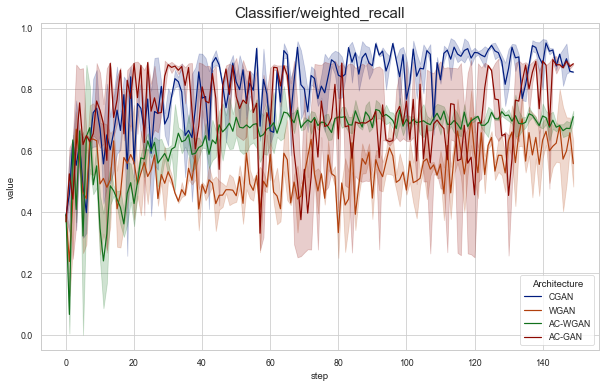

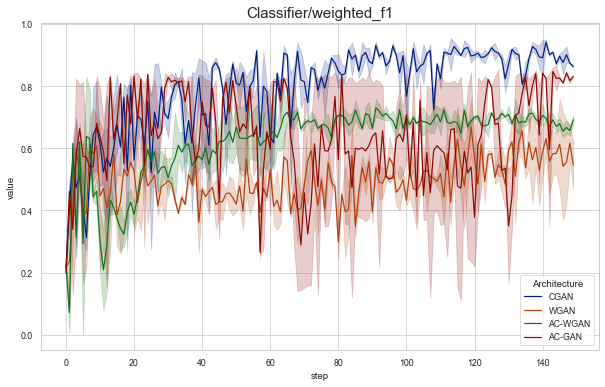

In [23]:
for metric in ['Classifier/accuracy', 'Classifier/macro_precision', 'Classifier/macro_recall', 'Classifier/macro_f1',
               'Classifier/weighted_precision', 'Classifier/weighted_recall', 'Classifier/weighted_f1']:
    df_temp = df_tensorboard[df_tensorboard["Metric"] == metric]
    ax = sns.lineplot(
        data=df_temp, 
        x="step",
        y="value",
        hue="Architecture"
    )
    ax.set_title(f"{metric}", fontsize=15)
    plt.savefig(f"{save_dir / metric.split('/')[1]}.png")
    plt.show()

#### Significance tests

#### Distances

### CGAN

#### Classifier predictions

## Validate classifier predictions (dynamic condition vectors)

In [ ]:
from utils import convert_levels_to_condition_vectors, labels_to_labelidx
from networks import GeneratorWithCondition, DiscriminatorWithCondition

In [3]:
num_features, num_labels, condition_size = 79, 14, 41
condition_vector_dict = torch.load("./data/cic-ids-2017_splits/seed_0/dynamic_condition_vector_dict.pt")

G = GeneratorWithCondition(num_features, num_labels, condition_size, latent_dim=128)
D = DiscriminatorWithCondition(num_features, condition_size)
gan = CGAN(G, D, None, None, use_dynamic_condition_vectors=True, condition_vector_dict=condition_vector_dict)
gan.load_model("./models/cgan_with_dynamic_condition_vector/20-06-2021_08h09m/model-149.pt", load_optimizer=False)

classifier = joblib.load("./models/classifier/20-05-2021_12h01m/classifier.gz")
scaler = joblib.load("./data/cic-ids-2017_splits/seed_0/min_max_scaler.gz")
label_encoder = joblib.load("./data/cic-ids-2017_splits/seed_0/label_encoder.gz")

label_distribution = {0: 0.01, 1: 0.23, 2: 0.02, 3: 0.38, 4: 0.01, 5: 0.01, 6: 0.015,
                      7: 0.01, 8: 0.01, 9: 0.265, 10: 0.01, 11: 0.01, 12: 0.01, 13: 0.01}
label_weights = list(label_distribution.values())

Loaded G weights.
Loaded D weights.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
/Users/thomas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                       Bot       0.84      0.40      0.54       127
                      DDoS       0.82      0.82      0.82      2317
             DoS GoldenEye       0.79      0.84      0.81       172
                  DoS Hulk       0.84      0.90      0.87      3752
          DoS Slowhttptest       0.32      0.73      0.45       108
             DoS slowloris       0.28      0.25      0.26        99
               FTP-Patator       0.93      0.79      0.86       156
                Heartbleed       0.00      0.00      0.00       117
              Infiltration       0.00      0.00      0.00       112
                  PortScan       0.98      1.00      0.99      2665
               SSH-Patator       0.85      0.52      0.65        84
  Web Attack  Brute Force       0.44      0.84      0.58       100
Web Attack  Sql Injection       0.00      0.00      0.00       105
          Web Attack  XSS       0.50      0.03

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


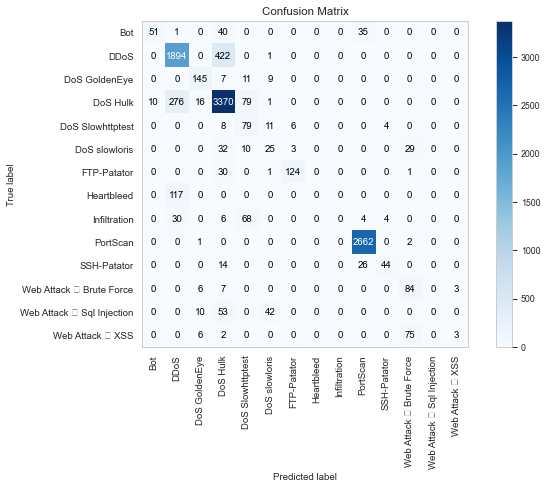

In [4]:
# 10000 random flows
flows, labels, condition_vectors = gan.generate(10000, label_weights, scaler=scaler, label_encoder=label_encoder)
label_preds = label_encoder.inverse_transform(classifier.predict(flows))
print(classification_report(labels, label_preds))
plot_confusion_matrix(labels, label_preds, x_tick_rotation=90)

### Validate dynamic condition vector level generation

We want to validate whether we can control the generation process. 

Therefore, we evaluate the condition for each feature (e.g. `Flow Duration`) indiviually. We have 3 kinds of features:
- features with three levels based on computes quantiles (low/mid/high) such as `Flow Duration`
- binary features, the flag features (e.g., `ACK Flag Count`)
- and the `Destination Port` feature that is mapped to its 16-bit representation

We examine each feature individually.


TBC

In [5]:
cgan_generation_control_dir = save_dir / "generation_control"
cgan_generation_control_dir.mkdir(parents=True, exist_ok=True)

#### Three-level features
First, we plot the three-level features. We compute 1000 flows per level per class (i.e., 30K flows per feature * 14 classes) and average their 
feature values to obtain the estimate of how well the output generation can be controlled. . 
The bars in the barplots represent the mean feature value for each level and the error bars show the 95% confidence interval. 

From the plots we see that overall, the GAN learns to control the generation process pretty well. For most feature and most classes we see a clear distinction between the three levels. 

Additionally, we also compute a simple `average success rate` for the generated features, i.e., if we specify high, the mean feature value should be the highest among the generated low/mid/high mean feature values. We compute this success rate as follows: 
- if `low` is specifed, and mean feature value is lower than mean feature values of `mid` and `high`, add +1 to the score
- if `mid` is specifed, and mean feature value is higher than mean feature value of `low`, but lower than `high`, add +1 to the score
- if `high` is specifed, and mean feature value is higher than mean feature values of `low` and `mid`, add +1 to the score

i.e., add +1 if the specified level is in the right position. 

The score is computed for each feature and attack type. The best possible score for each feature and each attack type is 3. 
We have 7 three-level features and 14 attack types. Hence, the max possible score is 7 * 14 * 3 = 294
To obtain the overall success score, we sum all scores and divide by 294. 

In fact, it would be better to use statistical significance tests between the distributions of the individual levels, but for computational reasons we only compare the mean scores. 


/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


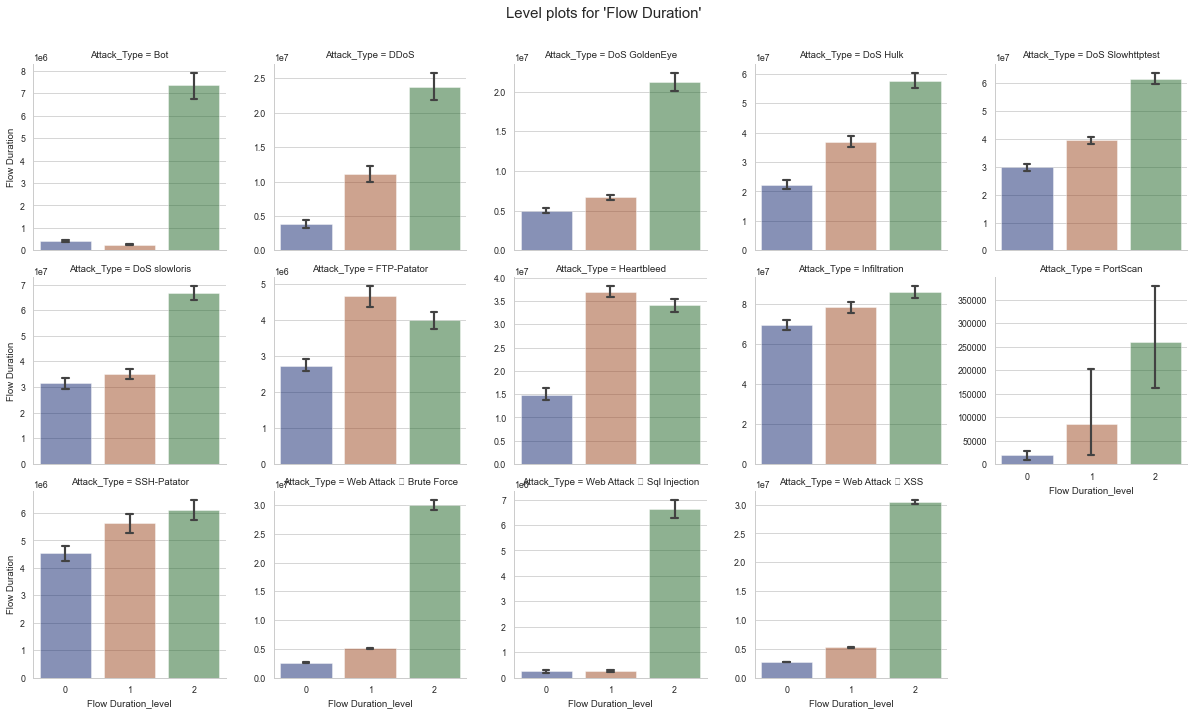

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


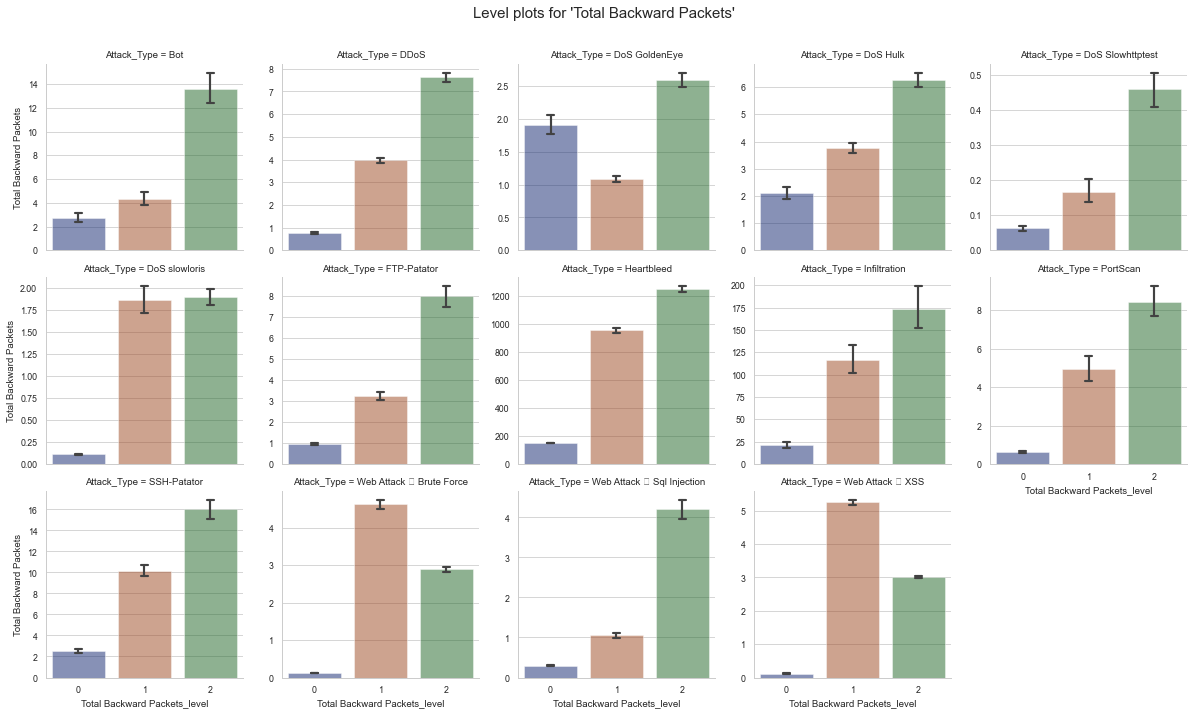

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


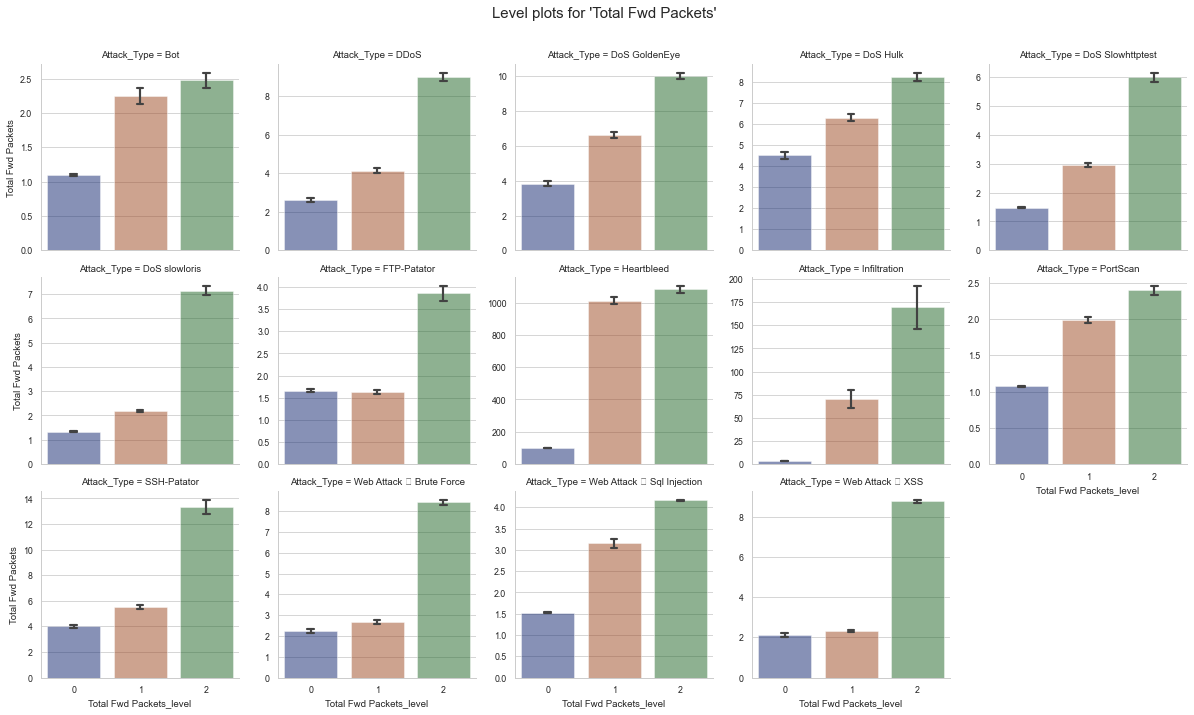

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


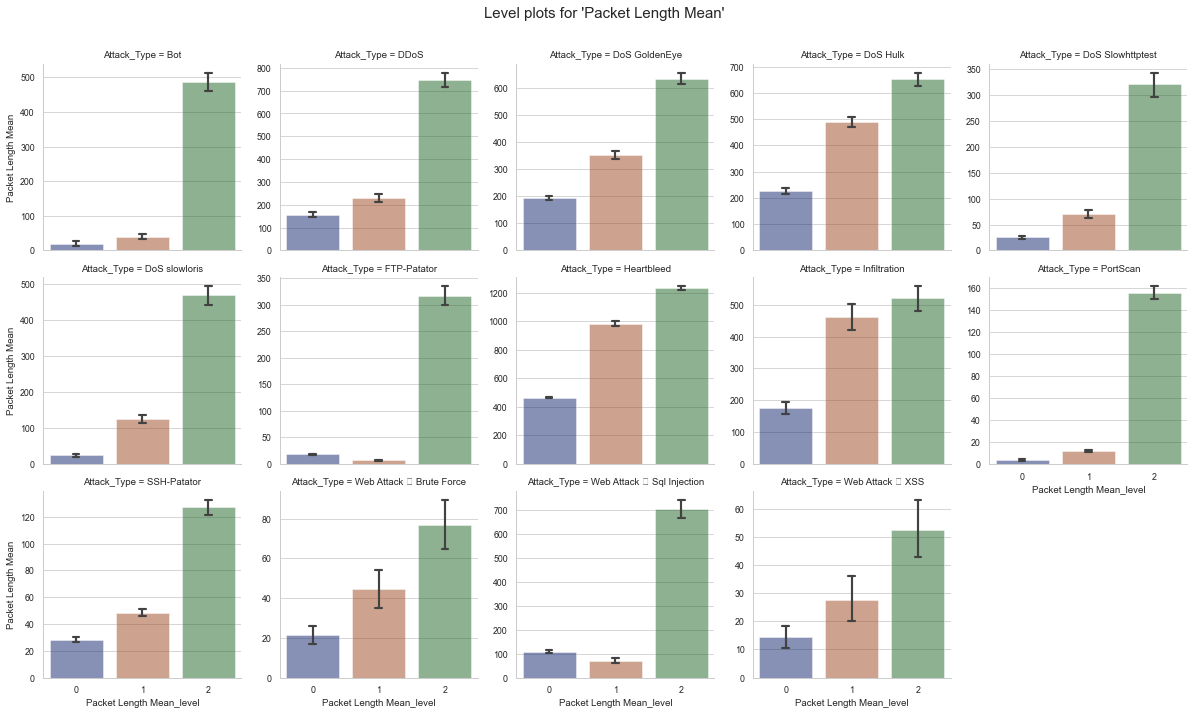

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


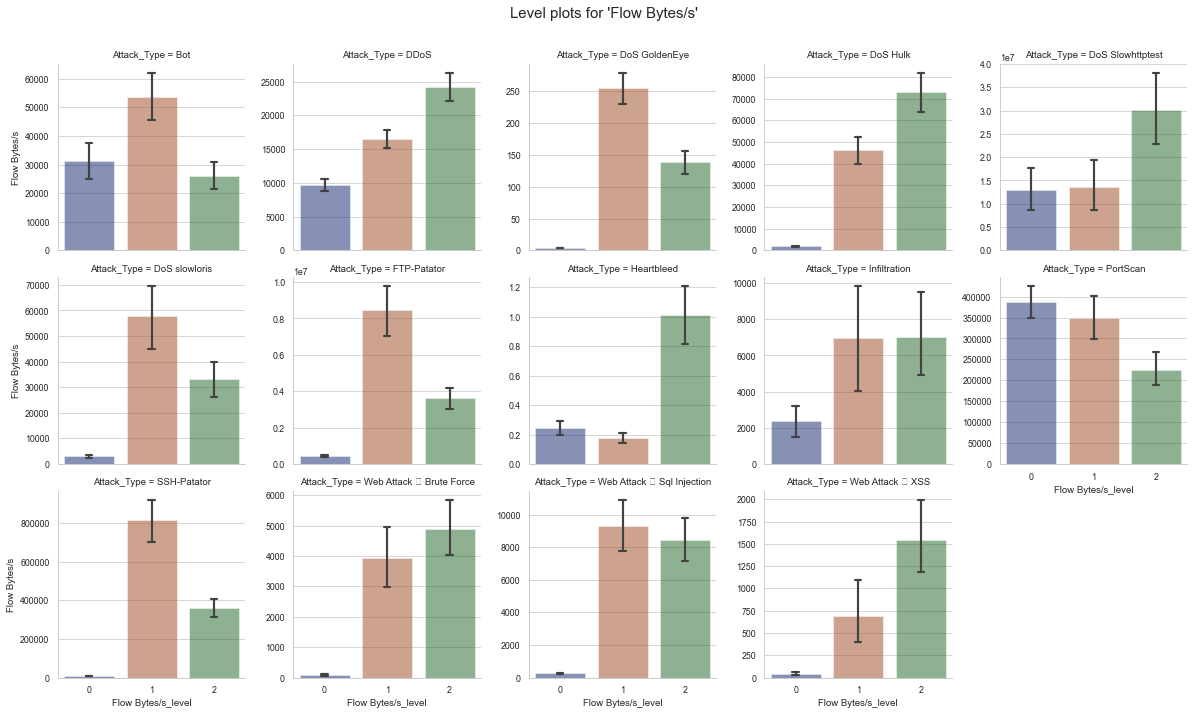

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


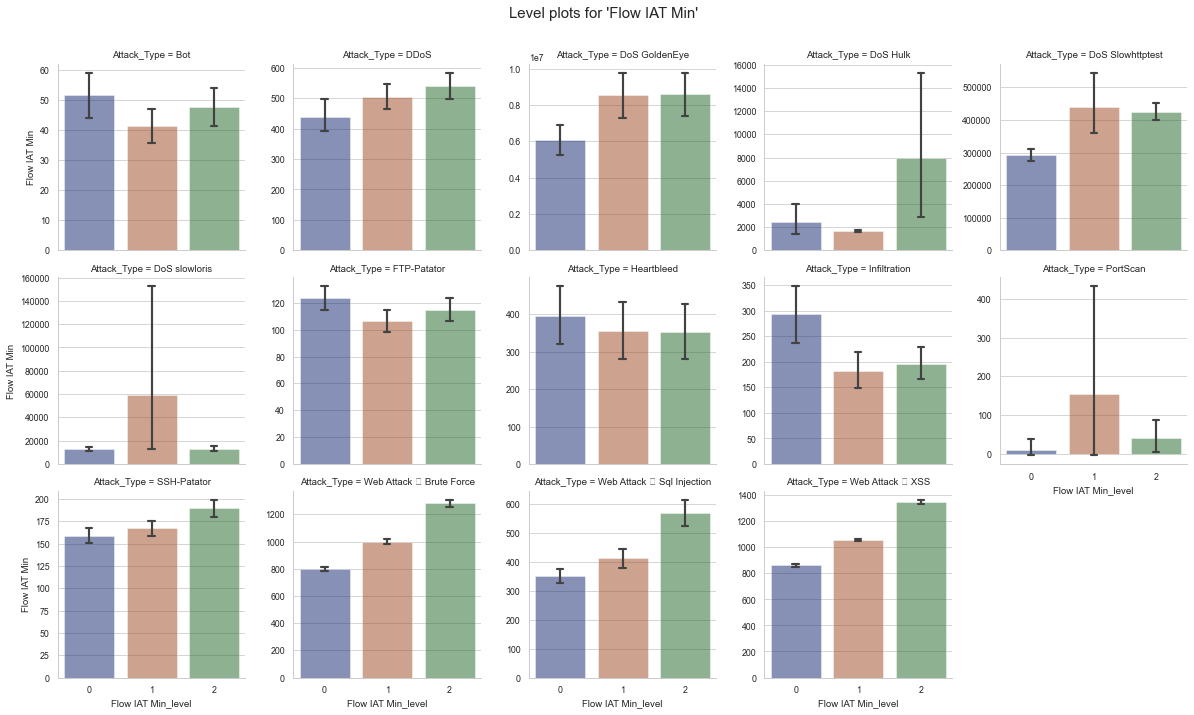

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


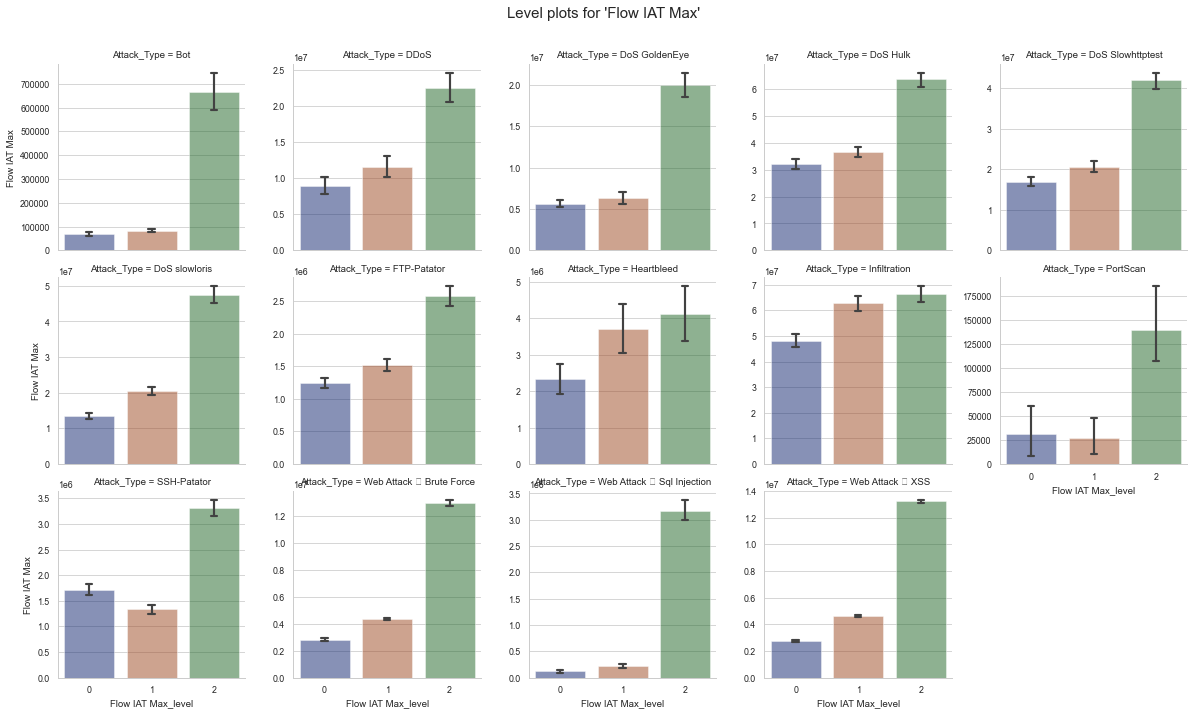

In [6]:
# setup 
n_flows_per_level = 1000
all_attacks = utils.get_label_names()[:-1]
attack_types = np.repeat(all_attacks, 3 * n_flows_per_level)
catplot_args = {
    "kind": "bar",
    "col_wrap": 5,
    "height": 3.3,
    "sharey": False,
    "ci": 95,
    "capsize":0.1,  # controls the size of horizontal lines in errorbars
    "alpha": 0.5
}


# generate 
success_scores = []
features = ['Flow Duration', 'Total Backward Packets', 'Total Fwd Packets', 'Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Min', 'Flow IAT Max']
for feature in features:
    levels = [{feature: 0}, {feature: 1},  {feature: 2}] * n_flows_per_level * len(all_attacks)
    df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)

    ax = sns.catplot(
        x=feature + "_level",
        y=feature, 
        col="Attack_Type", 
        data=df_results,
        **catplot_args
    )
    ax.fig.subplots_adjust(top=0.9)
    ax.fig.suptitle(f"Level plots for '{feature}'", fontsize=15)
    ax.savefig(f"{cgan_generation_control_dir / feature.replace('/', '')}.png")
    plt.show()
    
    # compute success scores
    df_temp = df_results.groupby(["Attack_Type", feature + "_level"])[feature].mean().reset_index()
    for attack in all_attacks:
        df_temp_attack = df_temp[df_temp["Attack_Type"] == attack]
        level_0 = df_temp_attack[df_temp_attack[feature + "_level"] == 0][feature].values
        level_1 = df_temp_attack[df_temp_attack[feature + "_level"] == 1][feature].values
        level_2 = df_temp_attack[df_temp_attack[feature + "_level"] == 2][feature].values
        
        success_scores.append({"Feature": feature, "Attack_Type": attack, "Level": 0, "Score": int(level_0 < level_1 and level_0 < level_2),
                              "Mean Feature val": round(level_0[0], 2)})
        success_scores.append({"Feature": feature, "Attack_Type": attack, "Level": 1, "Score": int(level_0 < level_1 < level_2),
                              "Mean Feature val": round(level_1[0], 2)})
        success_scores.append({"Feature": feature, "Attack_Type": attack, "Level": 2, "Score": int(level_2 > level_0  and level_2 > level_1),
                              "Mean Feature val": round(level_2[0], 2)})
success_scores = pd.DataFrame(success_scores)
success_scores.to_csv(cgan_generation_control_dir / "raw_success_scores_three_levels.csv", index=False)

Next, we actually compute the success scores. First, we compute it over all trial and obtain a score or ~78%. Hence, over all features and attack types 78% of the time the right ordering was produced from the input conditions. 

Furthermore, we can compute these scores for the individual levels. We see that 
- for the `low` and `high` levels ~82% of all conditions gave the right position
- for the `mid` level that number was at ~70%

We do the same per Feature and Attack Type. 
For features, we see that:
- `Flow Bytes/s` and `Flow IAT Min` have the lowest scores (~0.48, ~0.6 respectively)
- `Flow Duration`, `Flow IAT Max`, `Packet Length Mea`, `Total Backward Packet`, `Total Fwd Packets` have considerably higher scores


For attack types we observe that:
- `Bot`, `FTP-Patator`, `PortScan` obtain the lowest scores

In [7]:
success_scores

,Feature,Attack_Type,Level,Score,Mean Feature val
0,Flow Duration,Bot,0,0,425136.21
1,Flow Duration,Bot,1,0,251429.37
2,Flow Duration,Bot,2,1,7342799.44
3,Flow Duration,DDoS,0,1,3783744.99
4,Flow Duration,DDoS,1,1,11120123.23
...,...,...,...,...,...
289,Flow IAT Max,Web Attack  Sql Injection,1,1,213622.07
290,Flow IAT Max,Web Attack  Sql Injection,2,1,3175314.43
291,Flow IAT Max,Web Attack  XSS,0,1,2751525.66
292,Flow IAT Max,Web Attack  XSS,1,1,4612994.22


In [8]:
# average success score
total_score = success_scores["Score"].sum()
print("Total achieved score: ", total_score)
print("Max possible score: ", len(success_scores))
print("Average success ratio: ", total_score / len(success_scores))

Total achieved score:  234
Max possible score:  294
Average success ratio:  0.7959183673469388


In [9]:
# average success scores by level, divide by 3 as we have 3 levels
(success_scores.groupby("Level")["Score"].sum() / (len(success_scores) / 3)).to_frame()

,Score
Level,
0,0.846939
1,0.724490
2,0.816327


In [10]:
# average success scores by Feature, divide by 7 as we have 7 features
(success_scores.groupby("Feature")["Score"].sum() / (len(success_scores) / 7)).to_frame()

,Score
Feature,
Flow Bytes/s,0.571429
Flow Duration,0.857143
Flow IAT Max,0.904762
Flow IAT Min,0.523810
Packet Length Mean,0.904762
Total Backward Packets,0.857143
Total Fwd Packets,0.952381


In [11]:
# average success scores by Attack Type, divide by 14 as we have 14 features
(success_scores.groupby("Attack_Type")["Score"].sum() / (len(success_scores) / 14)).to_frame()

,Score
Attack_Type,
Bot,0.619048
DDoS,1.000000
DoS GoldenEye,0.809524
DoS Hulk,0.904762
DoS Slowhttptest,0.904762
DoS slowloris,0.809524
FTP-Patator,0.476190
Heartbleed,0.666667
Infiltration,0.857143


#### Binary features (flags)

Next, we visualize the generation process for the binary flag features. (`0=flag, 1=no_flag`)

The GAN produces real-value outputs, hence the produced values for the flags is in range [0, 1]. Therefore, it is not exactly 0 or 1 in most cases. For this reason we also round the generated outputs.
Next, we plot generated outputs using countplots. The blue bars represent the total number of 0s (`flag`) that were generated. Likewise, the organge bars represent the total number of 1s (`no_flag`) that were generated. The inputs to the GAN represent 50% `flags` and 50% `no_flag`. Hence, if it does well the bars should be of the same length.

We see that overall, the model is partly able to distinguish between "flag"/"no-flag" inputs. However, we also see that it is much more likely to produce "no-flag" than "flag". One reason for this is that Flags seldom occur in the dataset and hence it is biased towards not generating it. This also depends on the flag type. For example, `RST Flag` is never present in the dataset, therefore the model does not generate it at all, even if it is tasked to. 


However, the visualization is suboptimal. Therefore we also compute the "generation" accuracy and f1-scores, i.e., if the task is to produce flows with flags, how many of the generated flows contain flags. 


/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


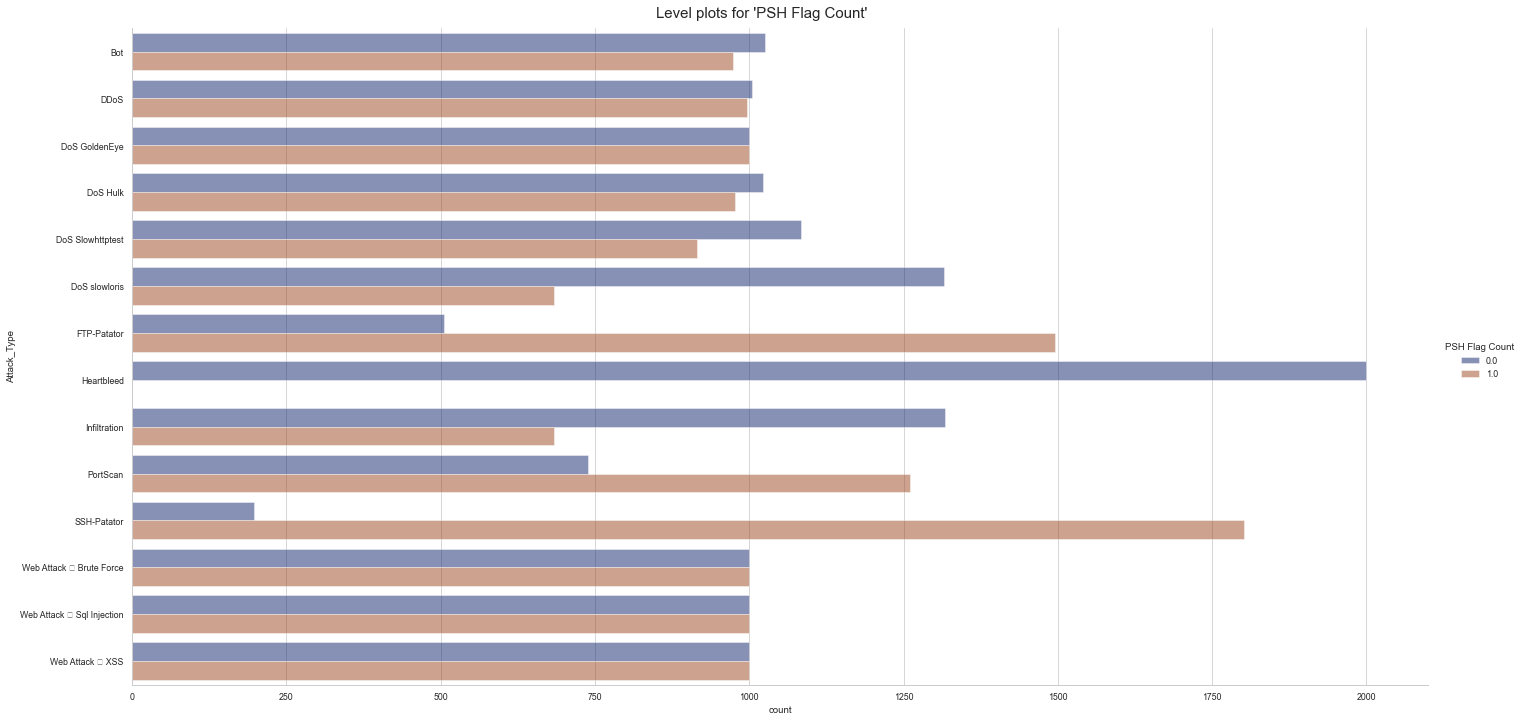

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


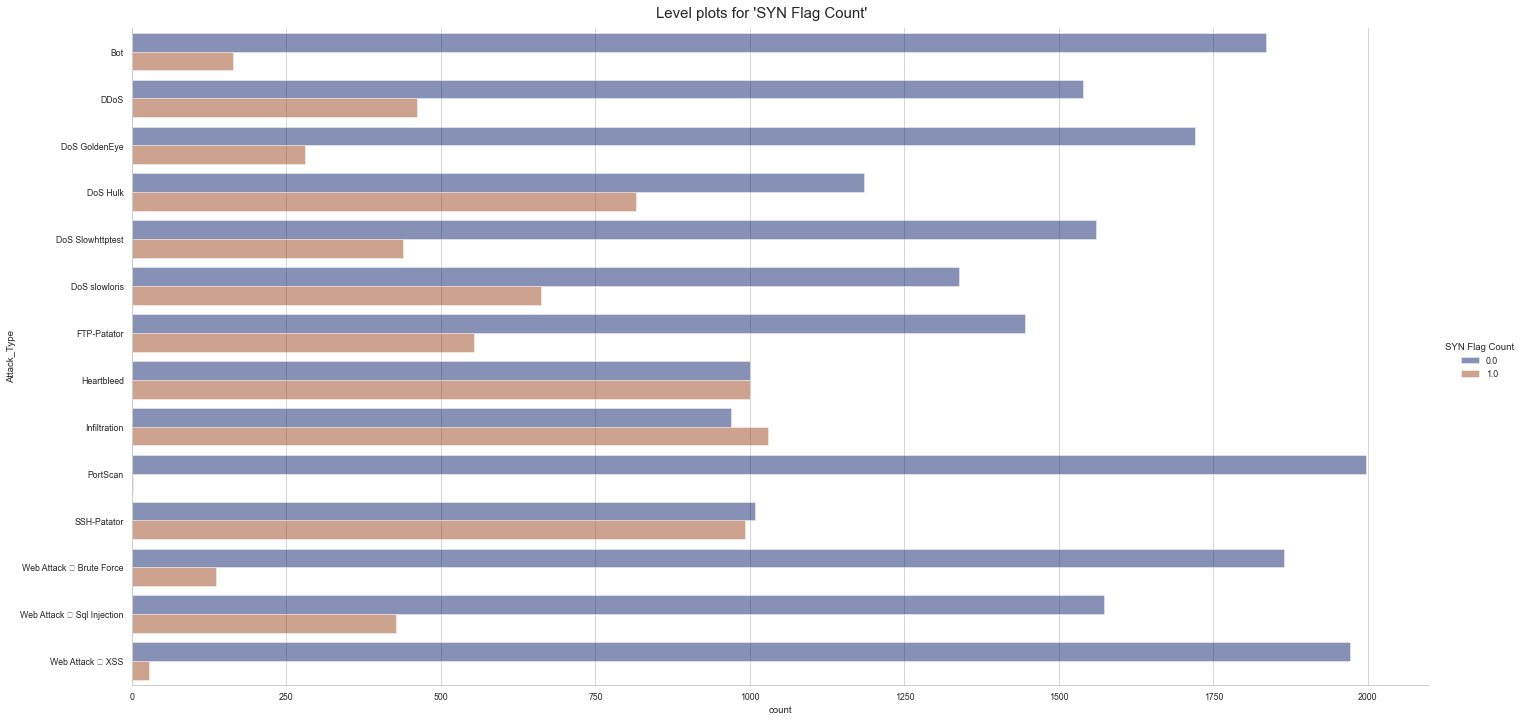

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


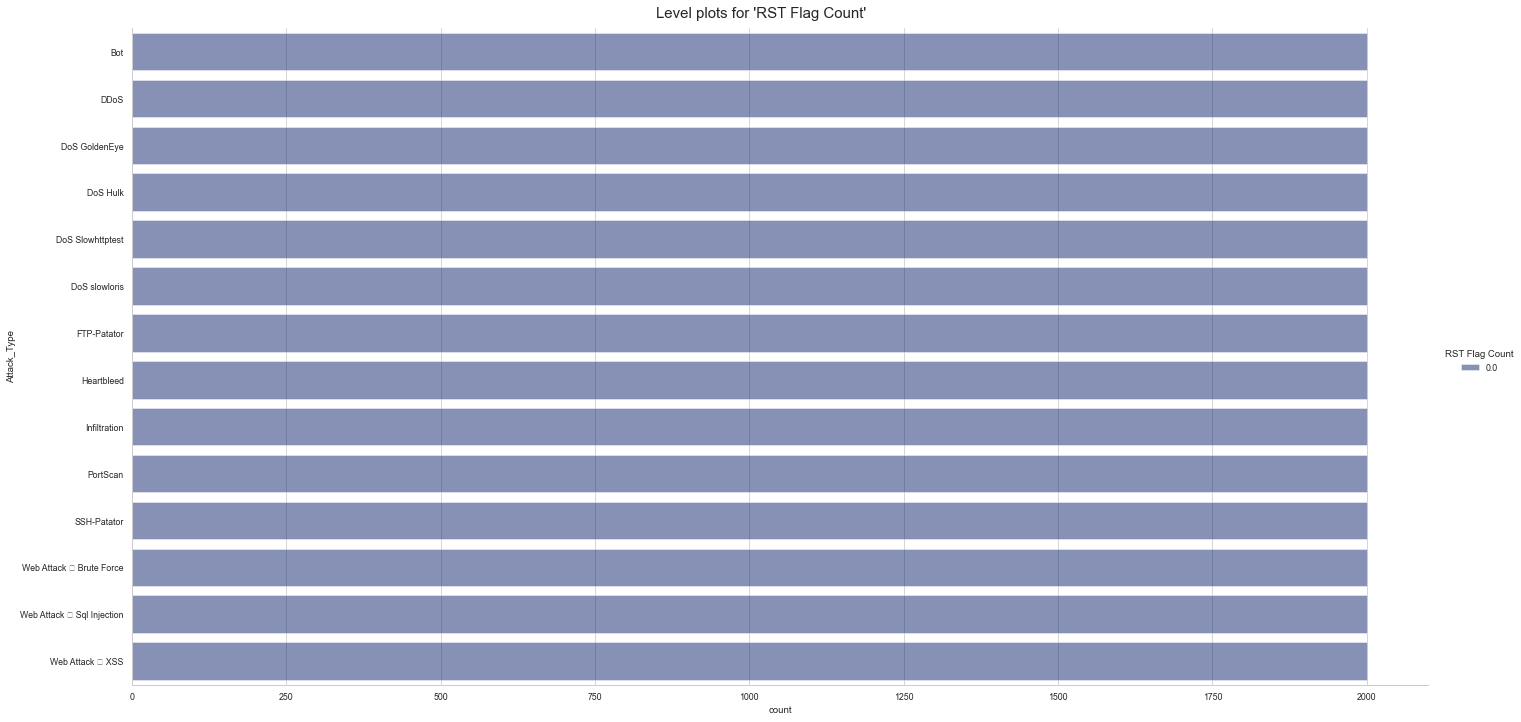

/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


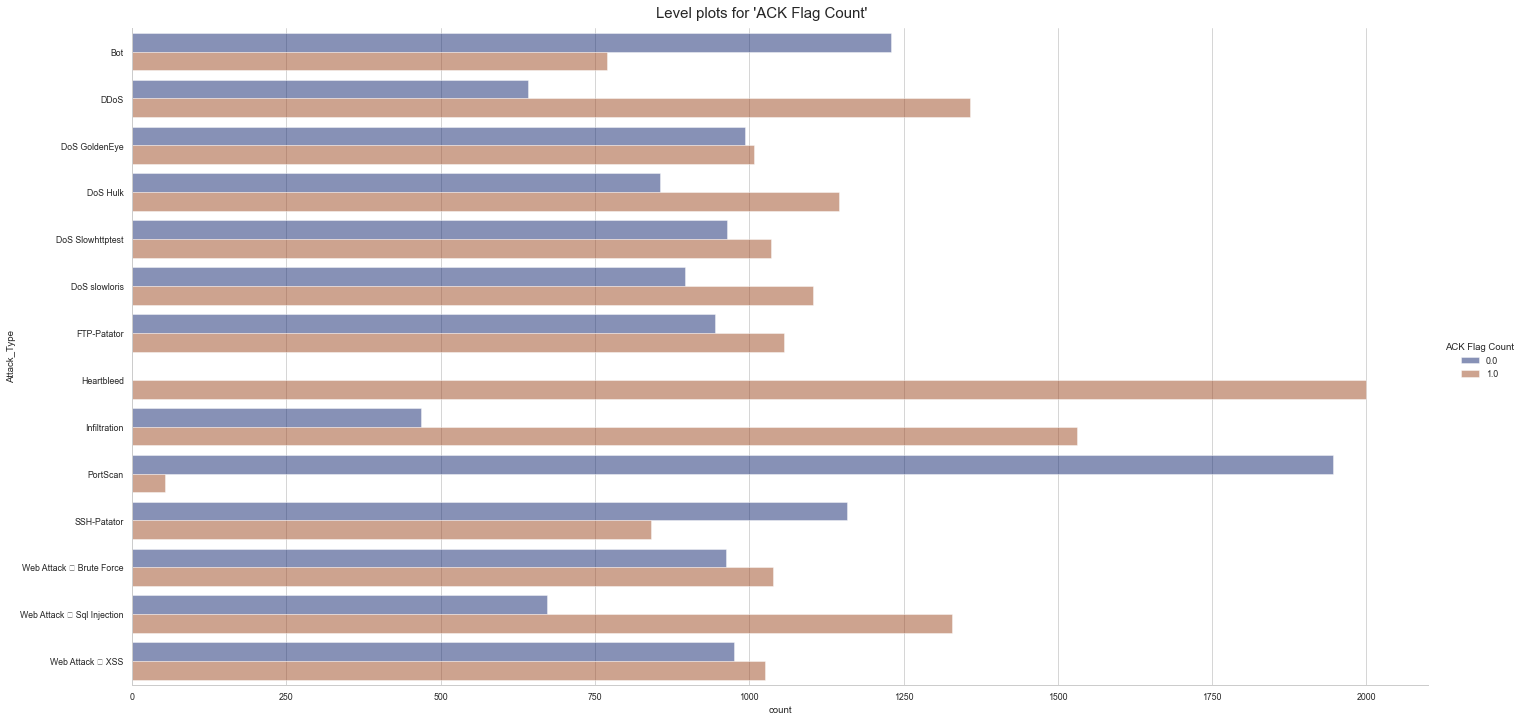

In [12]:
# generate 
n_flows_per_level = 1000
all_attacks = utils.get_label_names()[:-1]
attack_types = np.repeat(all_attacks, 2 * n_flows_per_level)
catplot_args = {
    "kind": "count",
    "height": 10,
    "aspect": 2,
    "alpha": 0.5,
}

flag_scores = []
flag_features = ['PSH Flag Count', 'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count']
for feature in flag_features:
    levels = [{feature: 0}, {feature: 1}] * n_flows_per_level * len(all_attacks)
    df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)
    df_results[feature] = df_results[feature].round()
        
    ax = sns.catplot(
        y="Attack_Type",
        hue=feature, 
        # col=feature+"_level",
        data=df_results,
        **catplot_args
    )
    ax.fig.subplots_adjust(top=0.95)
    ax.fig.suptitle(f"Level plots for '{feature}'", fontsize=15)
    ax.savefig(f"{cgan_generation_control_dir / feature.replace('/', '')}.png")
    plt.show()
    
    for attack in all_attacks:
        df_temp = df_results[df_results["Attack_Type"] == attack]
        f1 = f1_score(df_temp[feature + '_level'], df_temp[feature])
        acc = accuracy_score(df_temp[feature + '_level'], df_temp[feature])
        flag_scores.append({"Feature": feature, "Attack_Type": attack, "F1": f1, "Accuracy": acc})
        
flag_scores = pd.DataFrame(flag_scores)
flag_scores.to_csv(cgan_generation_control_dir / "raw_flag_scores.csv", index=False)

Overall, we see that the prediciton accuracy is relatively high for `PSH Flag Count`, moderately high for `ACK Flag Count` and `SYN Flag Count`, but random for `RST Flag Count`.

In [13]:
display(
    flag_scores.groupby("Feature").mean(),
    flag_scores.groupby("Attack_Type").mean(),
    flag_scores.mean()
)

,F1,Accuracy
Feature,,
ACK Flag Count,0.762407,0.774893
PSH Flag Count,0.853562,0.880929
RST Flag Count,0.000000,0.500000
SYN Flag Count,0.587324,0.746000


,F1,Accuracy
Attack_Type,,
Bot,0.506984,0.714000
DDoS,0.618888,0.761875
DoS GoldenEye,0.590566,0.766125
DoS Hulk,0.699200,0.825875
DoS Slowhttptest,0.600303,0.752375
DoS slowloris,0.630676,0.770750
FTP-Patator,0.515080,0.640625
Heartbleed,0.416667,0.625000
Infiltration,0.634717,0.750000


F1          0.550823
Accuracy    0.725455
dtype: float64

To set the results in contrast, we actually have to compute the proportions of flag usage in the original dataset. In this evaluation we used a 50% flows with flags and 50% flags without flags. We see that in the original dataset `RST Flag Count` is always 0. Hence, the model has no chance to learn this relation (we could have dropped this feature, but this nicely shows the difference). For `PSH Flag Count` and `ACK Flag Count` we see that for about half of the flows the flags is present and for half of them it is not. Finally we see that for `SYN Flag Count` the flag is hardly present. Our results reflect this well. 

In [14]:
train_dataset = CIC17Dataset(
    "./data/cic-ids-2017_splits/seed_0/train_dataset.pt",
    is_scaled=False
)
df_train = pd.DataFrame(np.append(train_dataset.X, train_dataset.y.reshape(-1, 1), axis=1), columns=train_dataset.column_names)
df_train["Label"] = train_dataset.label_encoder.inverse_transform(df_train["Label"].astype(int))

In [15]:
df_train[flag_features + ["Label"]].describe().round(3)

,PSH Flag Count,SYN Flag Count,RST Flag Count,ACK Flag Count
count,528728.000,528728.000,528728.0,528728.000
mean,0.462,0.012,0.0,0.432
std,0.499,0.109,0.0,0.495
min,0.000,0.000,0.0,0.000
25%,0.000,0.000,0.0,0.000
50%,0.000,0.000,0.0,0.000
75%,1.000,0.000,0.0,1.000
max,1.000,1.000,0.0,1.000


If we look at the proportions for each class separately, we can also see why the model does "poorly" for some attack types. For example, for `Bot, DDoS, DoS GoldenEye, DoS Hulk, Heartbleed, Web Attack Brute Force, Web Attack Sql Injection and Web Attack XSS` the `SYN Flag` is never set. Therefore, the model actually does the right thing when it resists to set the flag.

In [16]:
df_train.groupby("Label")[flag_features].mean().round(3)

,PSH Flag Count,SYN Flag Count,RST Flag Count,ACK Flag Count
Label,,,,
Bot,0.622,0.000,0.0,0.378
DDoS,0.455,0.000,0.0,0.546
DoS GoldenEye,0.716,0.000,0.0,0.286
DoS Hulk,0.064,0.000,0.0,0.681
DoS Slowhttptest,0.766,0.163,0.0,0.234
DoS slowloris,0.670,0.316,0.0,0.330
FTP-Patator,0.502,0.496,0.0,0.498
Heartbleed,0.091,0.000,0.0,0.909
Infiltration,0.176,0.559,0.0,0.824


#### Destination Port feature

Finally, we evaluate how well the `Destination Port` feature can be controlled. 

Different attacks are carried out on different ports. Therefore, for each attack it only makes sense to control for the ports that occur in the dataset.

However, for most only a single Port is relevant (e.g., port 80 for DoS and web attacks):
- `DDoS`: port 80
- `DoS Hulk`: port 80
- `DoS Slowhttptest`: port 80
- `DoS GoldenEye`: port 80
- `DoS slowloris`: port 80
- `FTP-Patator`: port 21
- `SSH-Patator`: port 22
- `Web Attack \x96 Brute Force`: port 80
- `Web Attack \x96 XSS`: port 80
- `Web Attack \x96 Sql Injection`: port 80
- `Infiltration`: port 444
- `Heartbleed`: port 444


Only for `PortScan` and `Bot` different ports are used. 

However, it is likely the GAN is not able to generate the given port number exactly. Therefore, we show the distribution using boxplots for different port number inputs. 

For `DDoS`, `DoS Hulk`, `DoS Slowhttptest`, `DoS GoldenEye`, `DoS slowloris`, `Web Attack \x96 Brute Force`, `Web Attack \x96 XSS`, `Web Attack \x96 Sql Injection` we use three input puts:
- 80, 20 and 120
- for all of them port 80 is what they see during training. 

Indeed, the network is not able to set the port number exactly. However, we can observe that for port 80 the distribution is more narrow around the value 80. Similary, for port 20 it is overall lower and for port 120 the distribution is higher. But they are both biased towards port 80.

Next, we do the same for `Infiltration` and `Heartbleed` using the ports 444, 20 and 80, where 444 is the default port. However, for these it doesn't work at all, as we only have a handful of samples in the training dataset. Finally, we do the same for `FTP-Patator` and `SSH-Patator` that have default ports 21 and 22 respectively.

These results show that overall it does not make much sense to control this feature or even to generate it. For the attack to be realistic (or for it to work in practice), it is necessary that the port number is set correctly. As there are only a handful of relevant ports, it is better to set them manually.


Finally, we do the same for `PortScan` and `Bot`. These attacks do not operate on a single port, so there is more variability in the dataset. We pick 5 of the most often occuring ports for this attack type and there we do see a clear distinction among the generated port distributions. Nevertheless, the utility is not clear. 


In [17]:
# for each attack type compute 10 most frequently occuring ports (proportions are shown)
n_most_frequent = 10

ports_per_attack_type = dict()
for label in df_train.Label.unique():
    counts = df_train[df_train["Label"] == label]["Destination Port"].value_counts(normalize=True).nlargest(n_most_frequent).to_dict()
    ports_per_attack_type[label] = counts

ports_per_attack_type

{'PortScan': {80.0: 0.0023398557641319336,
  22.0: 0.0015709513203945274,
  443.0: 0.0015311804008908685,
  21.0: 0.0015112949411390391,
  444.0: 0.0013389542899565172,
  139.0: 0.0012395269911973698,
  445.0: 0.0011268427192703363,
  4001.0: 0.0010605578534309047,
  2045.0: 0.0010473008802630184,
  720.0: 0.0010473008802630184},
 'DDoS': {80.0: 0.9999835558771295,
  64873.0: 8.222061435243044e-06,
  27636.0: 8.222061435243044e-06},
 'DoS Hulk': {80.0: 1.0},
 'DoS Slowhttptest': {80.0: 1.0},
 'DoS GoldenEye': {80.0: 1.0},
 'FTP-Patator': {21.0: 0.9998673388166622, 80.0: 0.00013266118333775536},
 'Bot': {8080.0: 0.6367061356297093,
  4305.0: 0.0005382131324004305,
  52908.0: 0.0005382131324004305,
  52707.0: 0.0005382131324004305,
  53884.0: 0.0005382131324004305,
  51587.0: 0.0005382131324004305,
  52169.0: 0.0005382131324004305,
  53931.0: 0.0005382131324004305,
  3205.0: 0.0005382131324004305,
  53744.0: 0.0005382131324004305},
 'SSH-Patator': {22.0: 1.0},
 'DoS slowloris': {80.0: 1.

/Users/thomas/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/thomas/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


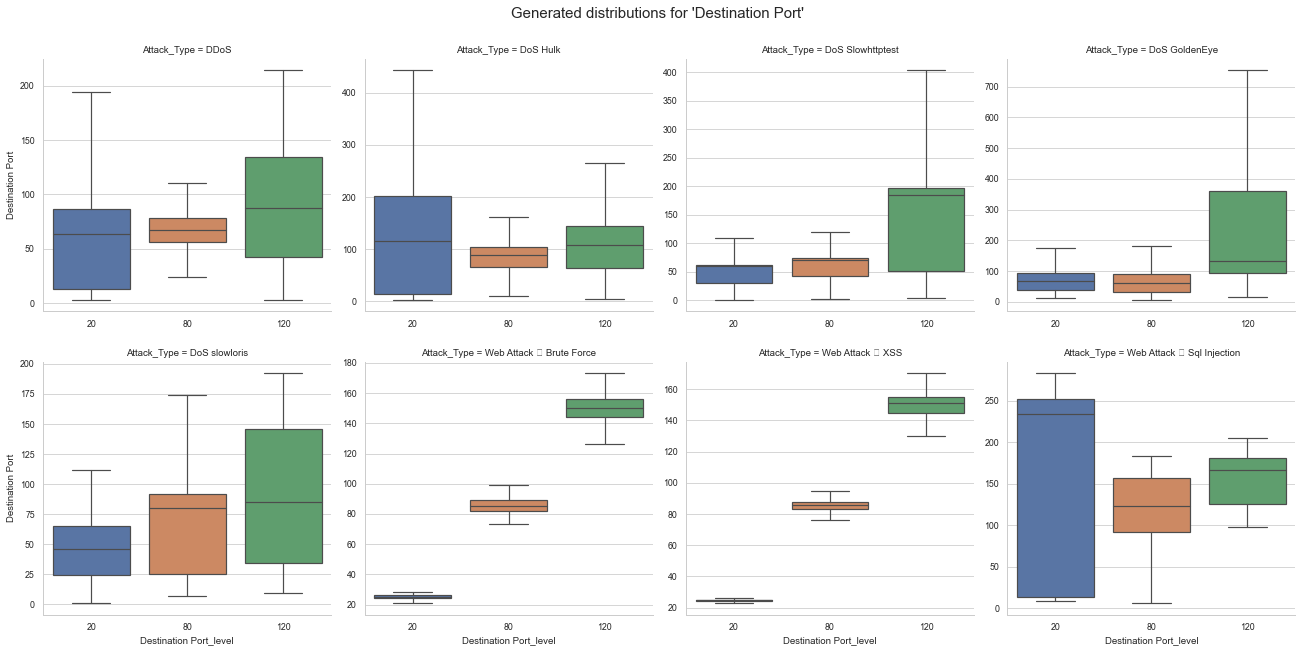

In [18]:
n_flows_per_level = 1000
feature = "Destination Port"
attacks_port_80 = ['DDoS', 'DoS Hulk', 'DoS Slowhttptest', 'DoS GoldenEye', 'DoS slowloris', 'Web Attack \x96 Brute Force', 'Web Attack \x96 XSS', 'Web Attack \x96 Sql Injection']
attack_types = np.repeat(attacks_port_80, 3 * n_flows_per_level)
catplot_args = {
    "kind": "box",
    "height": 4.5,
    "col_wrap": 4,
    "palette": "deep",
    "showfliers": False,
    "sharey": False,
    "sharex": False,
}


levels = [{feature: 80}, {feature: 20}, {feature: 120}] * n_flows_per_level * len(attacks_port_80)
df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)
df_results[feature] = df_results[feature].round()

ax = sns.catplot(
    x=feature+"_level",
    y=feature, 
    col="Attack_Type",
    data=df_results,
    **catplot_args
)


ax.fig.subplots_adjust(top=0.90, hspace=0.2)
ax.fig.suptitle(f"Generated distributions for '{feature}'", fontsize=15)
ax.savefig(f"{cgan_generation_control_dir / 'Destination Port 80'}.png")

/Users/thomas/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


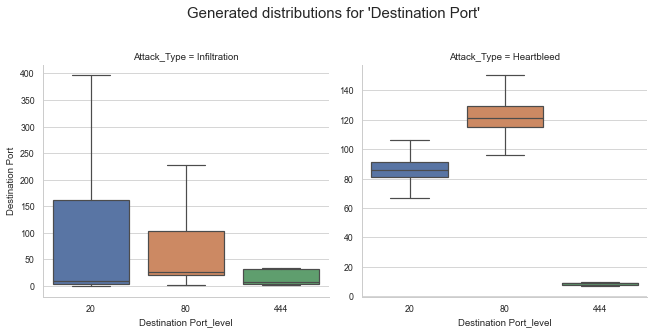

In [19]:
n_flows_per_level = 1000
feature = "Destination Port"
attacks_port_444 = ['Infiltration', "Heartbleed"]
attack_types = np.repeat(attacks_port_444, 3 * n_flows_per_level)
catplot_args = {
    "kind": "box",
    "height": 4.5,
#     "col_wrap": 2,
    "palette": "deep",
    "showfliers": False,
    "sharey": False,
    "sharex": False,
}


levels = [{feature: 444}, {feature: 80}, {feature: 20}] * n_flows_per_level * len(attacks_port_444)
df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)
df_results[feature] = df_results[feature].round()

ax = sns.catplot(
    x=feature+"_level",
    y=feature, 
    col="Attack_Type",
    data=df_results,
    **catplot_args
)


ax.fig.subplots_adjust(top=0.80)
ax.fig.suptitle(f"Generated distributions for '{feature}'", fontsize=15)
ax.savefig(f"{cgan_generation_control_dir / 'Destination Port 444'}.png")

/Users/thomas/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


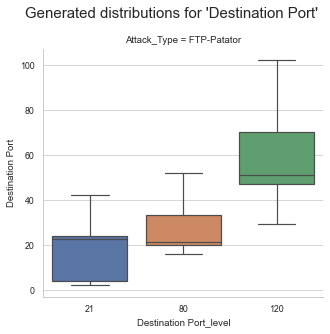

In [20]:
n_flows_per_level = 1000
feature = "Destination Port"
attacks_port_21 = ['FTP-Patator',]
attack_types = np.repeat(attacks_port_21, 3 * n_flows_per_level)
catplot_args = {
    "kind": "box",
    "height": 4.5,
#     "col_wrap": 2,
    "palette": "deep",
    "showfliers": False,
    "sharey": False,
    "sharex": False,
}


levels = [{feature: 21}, {feature: 80}, {feature: 120}] * n_flows_per_level * len(attacks_port_21)
df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)
df_results[feature] = df_results[feature].round()

ax = sns.catplot(
    x=feature+"_level",
    y=feature, 
    col="Attack_Type",
    data=df_results,
    **catplot_args
)


ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle(f"Generated distributions for '{feature}'", fontsize=15)
ax.savefig(f"{cgan_generation_control_dir / 'Destination Port 21'}.png")

/Users/thomas/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


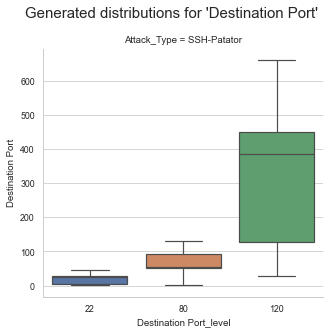

In [21]:
n_flows_per_level = 1000
feature = "Destination Port"
attacks_port_22 = ['SSH-Patator',]
attack_types = np.repeat(attacks_port_22, 3 * n_flows_per_level)
catplot_args = {
    "kind": "box",
    "height": 4.5,
#     "col_wrap": 2,
    "palette": "deep",
    "showfliers": False,
    "sharey": False,
    "sharex": False,
}


levels = [{feature: 22}, {feature: 80}, {feature: 120}] * n_flows_per_level * len(attacks_port_22)
df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)
df_results[feature] = df_results[feature].round()

ax = sns.catplot(
    x=feature+"_level",
    y=feature, 
    col="Attack_Type",
    data=df_results,
    **catplot_args
)


ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle(f"Generated distributions for '{feature}'", fontsize=15)
ax.savefig(f"{cgan_generation_control_dir / 'Destination Port 22'}.png")

/Users/thomas/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


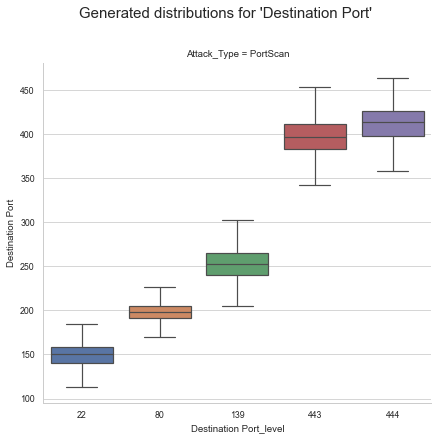

In [22]:
n_flows_per_level = 1000
feature = "Destination Port"
attacks_port_portscan = ['PortScan']
attack_types = np.repeat(attacks_port_portscan, 5 * n_flows_per_level)
catplot_args = {
    "kind": "box",
    "height": 6,
#     "col_wrap": 2,
    "palette": "deep",
    "showfliers": False,
    "sharey": False,
    "sharex": False,
}


levels = [{feature: 139}, {feature: 22}, {feature: 80}, {feature: 443}, {feature: 444}] * n_flows_per_level * len(attacks_port_portscan)
df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)
df_results[feature] = df_results[feature].round()

ax = sns.catplot(
    x=feature+"_level",
    y=feature, 
    col="Attack_Type",
    data=df_results,
    **catplot_args
)


ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle(f"Generated distributions for '{feature}'", fontsize=15)
ax.savefig(f"{cgan_generation_control_dir / 'Destination Port (PortScan)'}.png")

/Users/thomas/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


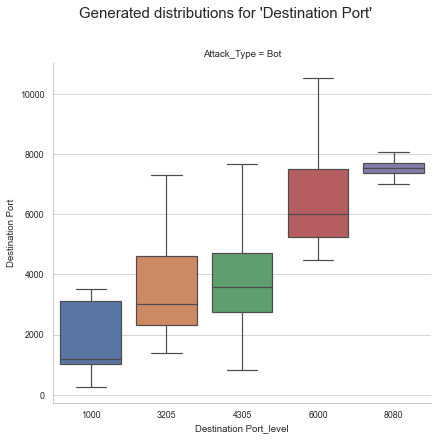

In [24]:
n_flows_per_level = 1000
feature = "Destination Port"
attacks_port_bot = ['Bot']
attack_types = np.repeat(attacks_port_bot, 5 * n_flows_per_level)
catplot_args = {
    "kind": "box",
    "height": 6,
#     "col_wrap": 2,
    "palette": "deep",
    "showfliers": False,
    "sharey": False,
    "sharex": False,
}


levels = [{feature: 8080}, {feature: 4305}, {feature: 3205}, {feature: 1000}, {feature: 6000}] * n_flows_per_level * len(attacks_port_bot)
df_results = utils.generate_from_levels(gan, levels, attack_types, scaler, label_encoder)
df_results[feature] = df_results[feature].round()

ax = sns.catplot(
    x=feature+"_level",
    y=feature, 
    col="Attack_Type",
    data=df_results,
    **catplot_args
)


ax.fig.subplots_adjust(top=0.85)
ax.fig.suptitle(f"Generated distributions for '{feature}'", fontsize=15)
ax.savefig(f"{cgan_generation_control_dir / 'Destination Port (Bot)'}.png")